## Inverse Kinematics Calculations For The Serial Link Arm

In [14]:
from sympy import *
import numpy as np

In [15]:
# pass the dh paramters matrix in order to construct 
# the A transformation for each frame to the one before

def construct_a_matrices(dh_matrix): 
    
    a_matrices = []

    for i in range(0, dh_matrix.rows):

        alpha = dh_matrix.row(i)[0]
        a = dh_matrix.row(i)[1]
        theta = dh_matrix.row(i)[2]
        d = dh_matrix.row(i)[3]

        # following the defualt model of the a matrix
        a_trans = Matrix([[cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha) , a*cos(theta)], 
                        [sin(theta), cos(theta)*cos(alpha) , -cos(theta)*sin(alpha), a*sin(theta)], 
                        [0         , sin(alpha)            , cos(alpha)            , d           ], 
                        [0         , 0                     , 0                     , 1           ]])

        a_matrices.append(a_trans)


    return a_matrices

In [16]:
# create transformation matrices from each frame to origin by 
# multiplying each a matrix to one another iteratively

def create_frame_to_origin_transformations(a_matrices):
    

    # start with an identity matrix because we need something to multiply the first matrix by
    trans = eye(4)


    # keep an array of each transformation matrix to construct jacobians later
    transformation_matrices = [trans]

    for matrix in a_matrices:
        trans = trans*matrix
        transformation_matrices.append(trans)


    return transformation_matrices

In [17]:
# construct the jacobian given the tranformation matrices for each frame to the world frame
# grab the z and o vectors for the previous and current frames repectively

def construct_jacobian(transformation_matrices):

    o_n = transformation_matrices[-1]*Matrix([0, 0, 0, 1])
    o_n.row_del(3)

    jacobian = Matrix()

    # start from index 1 to the end because we only want
    # 7 columns in the jacobian, one for each joint
    # we are just ignoring the identity matric in the first index
    for i in range(1, len(transformation_matrices)-1):

        # get the z_i-1 vector from the transformation matrix of the last frame
        z = transformation_matrices[i-1]*Matrix([0, 0, 1, 0])
        z.row_del(3)

        o_i = transformation_matrices[i]*Matrix([0, 0, 0, 1])
        o_i.row_del(3)

        jacobian_column = z.cross(o_n - o_i).col_join(z)
        jacobian = jacobian.row_join(jacobian_column)

    return jacobian

In [18]:
def generate_linear_slopes():

    # Generate the linear velocities that will be used in conjuntion with the instantaneous jacobian 
    # to derive the q_dot values

    dx  = []
    dy = []
    dz = []
    dth = []
    dphi = []
    drho = []


    # theta(t) = pi/2 + 2pi/5t

    # x = 0.18cos(pi/2 - pi/2*t)
    # dx = 0.36pi sin(pi/2 - pi/2*t)
    # z = 0.18sin(pi/2 - pi/2*t)
    # dz = -0.36pi cos(pi/2 - pi/2*t)


    for t in np.arange(0, 1, 0.02):
        dx.append(0.24*pi*sin(pi/2 - pi/2*t))
        dy.append(0)
        dz.append(-0.24*pi*cos(pi/2 - pi/2*t))
        dth.append(0)
        dphi.append(0)
        drho.append(0)

    return dx, dy, dz, dth, dphi, drho

In [19]:
def generate_poses(jacobian):

    pose = Matrix([0.01, 0, 0, 0, 0, 0])
    poses = [pose]

    dx, dy, dz, dth, dphi, drho = generate_linear_slopes()

    for i in range(len(dx)):
        inst_jacobian = jacobian.subs(theta_1, pose[0]).subs(theta_2, pose[1]).subs(theta_3, pose[2]).subs(theta_4, pose[3]).subs(theta_5, pose[4]).subs(theta_6, pose[5])
        inv = N(inst_jacobian.pinv())

        linear_slopes = Matrix([dx[i], dy[i], dz[i], dth[i], dphi[i], drho[i]])

        dq = N(inv*linear_slopes)
        
        pose = pose + (dq*0.02)
        pose = pose % N(pi/2)
        poses.append(pose)

        print(pose)

    return poses


In [20]:
def get_end_affector_position(ee_frame, poses):

    ee_positions = [[],[],[]]
    for pose in poses:
        ee_pos = ee_frame.subs(theta_1, pose[0]).subs(theta_2, pose[1]).subs(theta_3, pose[2]).subs(theta_4, pose[3]).subs(theta_5, pose[4]).subs(theta_6, pose[5])
        ee_pos = ee_pos*Matrix([0, 0, 0, 1])
        ee_positions[0].append(ee_pos[0])
        ee_positions[1].append(ee_pos[1])
        ee_positions[2].append(ee_pos[2])

        print(ee_pos)


    return ee_positions


In [21]:
# d1 = symbols('d1')
# d3 = symbols('d3')
# d5 = symbols('d5')
# d7 = symbols('d7')

d1 = 0.045
d3 = 0.06
d5 = 0.06
d_e = 0.06

theta_1 = symbols('theta_1')
theta_2 = symbols('theta_2')
theta_3 = symbols('theta_3')
theta_4 = symbols('theta_4')
theta_5 = symbols('theta_5')
theta_6 = symbols('theta_6')


dh_matrix = Matrix([[-pi/2, 0,theta_1, d1], 
                   [pi/2,  0, theta_2, 0], 
                   [-pi/2,  0, theta_3, d3], 
                   [pi/2, 0, theta_4, 0], 
                   [pi/2, 0, theta_5, d5], 
                   [-pi/2,  0, theta_6, 0], 
                   [0,     0,       0, d_e]])

                   


In [22]:
# calculate the paramteric jacobian based on the transformation matrices

a_matrices = construct_a_matrices(dh_matrix)
transformation_matrices = create_frame_to_origin_transformations(a_matrices)

j = construct_jacobian(transformation_matrices)
j.shape


(6, 6)

In [23]:
# generate poses for each iteration to draw the crcle

poses = generate_poses(j)

Matrix([[0.0100000000000000], [0.125657423010650], [0], [1.57079632679490], [0], [0.125657423010650]])
Matrix([[1.56075282374024], [0.375857122914374], [0.0198854698299375], [1.29694777426121], [1.56828433468810], [0.102008570380685]])
Matrix([[1.09391350354244], [0.493221589581401], [0.650222683133030], [1.31195143077325], [0.0855221894918294], [1.07715039721471]])
Matrix([[0.640763623813308], [0.610850376053435], [1.11035778669689], [1.31350555799317], [1.40678730086497], [1.04232234731442]])
Matrix([[0.847433484384496], [0.305745821270091], [0.281281873706792], [1.25101465635065], [0.319150309762524], [0.479664640790586]])
Matrix([[0.246210808920798], [0.476918058471577], [0.923541630001283], [1.12420116916009], [0.0873334741293456], [0.466390909274904]])
Matrix([[0.180458386234092], [0.725633736181526], [1.07835748480291], [0.922832257929055], [1.42112790219038], [0.390630055824352]])
Matrix([[0.939631619944492], [0.112190991099110], [0.249224810438225], [0.619529641220237], [0.006

In [24]:
ee_positions = get_end_affector_position(transformation_matrices[-1], poses)

Matrix([[0], [0], [0.225000000000000], [1]])
Matrix([[0.127040197050682], [0.00127044431893310], [0.0970073093284197], [1]])
Matrix([[0.00523530509117013], [0.141138032949372], [0.0886025870091373], [1]])
Matrix([[0.0177591895210178], [0.121516426251246], [0.134179551049453], [1]])
Matrix([[0.0648088676887354], [0.115129826646921], [0.0717017372993884], [1]])
Matrix([[0.0713209321513392], [0.109770540518599], [0.130542521490901], [1]])
Matrix([[0.0908440695998709], [0.0960894906089300], [0.137419211438939], [1]])
Matrix([[0.120095610035561], [0.0916853990439236], [0.102605152173677], [1]])
Matrix([[0.0166825167652608], [0.0285253517938070], [0.207756066045047], [1]])
Matrix([[0.0729910063287330], [0.0524663955292321], [0.172859456867096], [1]])
Matrix([[0.0490649754536558], [0.0840041778759271], [0.170091868691315], [1]])
Matrix([[0.0989586988684691], [0.0578332290458908], [0.154234410367544], [1]])
Matrix([[0.145520697451414], [0.0254596563987332], [0.0818142681924195], [1]])
Matrix([

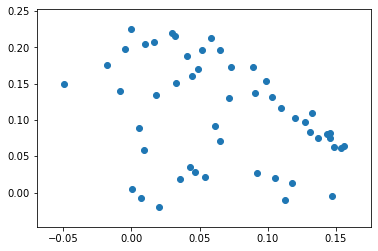

In [26]:
from matplotlib import pyplot as plt


plt.scatter(ee_positions[0], ee_positions[2])


# its skewing to the left by about 11, not sure why